In [ ]:
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from scipy.signal import resample

In [39]:
Xi,y = load_eeg_label_pair()
X = torch.from_numpy(resample(Xi.flatten(),86400*100)).reshape(-1,1000)
X = torch.from_numpy(RobustScaler().fit_transform(X.reshape(-1,1)).reshape(-1,100*10)).float()
X_train,X_dev,y_train,y_dev = train_test_split(X,y,test_size=.5,stratify=y,shuffle=True,random_state=0)
trainloader = DataLoader(TensorDataset(X_train,y_train),batch_size=32,shuffle=True)
devloader = DataLoader(TensorDataset(X_dev,y_dev),batch_size=32,shuffle=True)

In [217]:
class MODEL(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        n_feature_maps = 64
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=n_feature_maps,kernel_size=8,stride=1,bias=False,padding='same'),
            nn.LayerNorm(normalized_shape=(n_feature_maps,1000),elementwise_affine=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=n_feature_maps,out_channels=n_feature_maps,kernel_size=5,stride=1,bias=False,padding='same'),
            nn.LayerNorm(normalized_shape=(n_feature_maps,1000),elementwise_affine=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=n_feature_maps,out_channels=n_feature_maps,kernel_size=3,stride=1,bias=False,padding='same'),
            nn.LayerNorm(normalized_shape=(n_feature_maps,1000),elementwise_affine=False),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=1000)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=n_feature_maps,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=3)
        )
    def forward(self,x):
        x = x.view(-1,1,1000)
        x = self.encoder(x)
        x = self.classifier(x.squeeze(2))
        return x
model = MODEL().to('mps')
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

Params:  41987


In [218]:
train_lossi = []
dev_lossi = []
train_metrics = []
dev_metrics = []

In [228]:
for epoch in range(30):
    for Xi,yi in tqdm(trainloader):
        logits = model(Xi.to('mps'))
        loss = criterion(logits,yi.to('mps'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss,report,y_true,y_pred,y_logits = evaluate(trainloader,model,criterion,'mps')
    train_lossi.append(loss)
    train_metrics.append(report)
    loss,report,y_true,y_pred,y_logits = evaluate(devloader,model,criterion,'mps')
    dev_lossi.append(loss)
    dev_metrics.append(report)

100%|██████████| 135/135 [00:00<00:00, 181.58it/s]


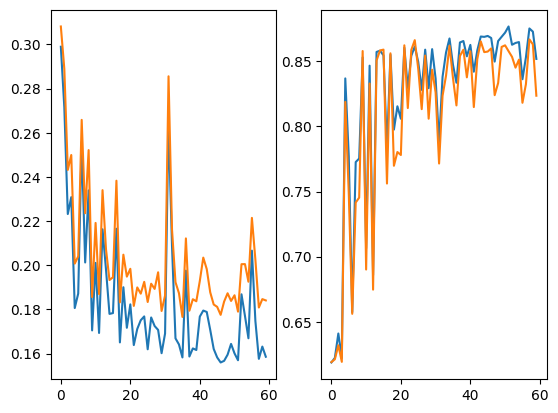

In [229]:
fig,axes = plt.subplots(nrows=1,ncols=2)
axes[0].plot(train_lossi)
axes[0].plot(dev_lossi)
axes[1].plot([metric['f1'] for metric in train_metrics])
axes[1].plot([metric['f1'] for metric in dev_metrics])

In [230]:
loss,report,y_true,y_pred,y_logits = evaluate(trainloader,model,criterion,'mps')
print(loss,report)
loss,report,y_true,y_pred,y_logits = evaluate(devloader,model,criterion,'mps')
print(loss,report)
# loss : .172
# f1 : .844

100%|██████████| 135/135 [00:00<00:00, 174.52it/s]


0.15858498530945292 {'precision': 0.9160520241985696, 'recall': 0.815139215057583, 'f1': 0.8518872918275188}


100%|██████████| 135/135 [00:00<00:00, 187.26it/s]

0.1840865794569254 {'precision': 0.8801469096187228, 'recall': 0.791508817134245, 'f1': 0.8236320772952691}


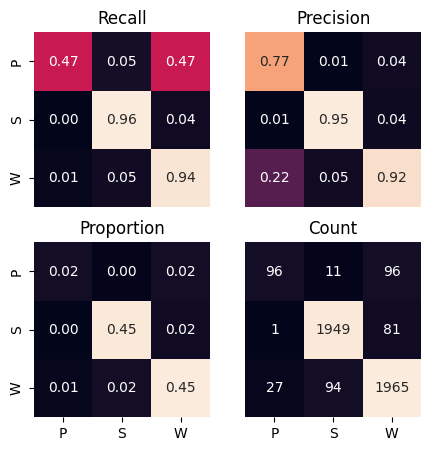

In [231]:
cm_grid(y_true,y_pred)

In [232]:
all_metrics = pd.DataFrame()

for id in get_ekyn_ids():
    X,y = load_eeg_label_pair(id)
    X = torch.from_numpy(resample(X.flatten(),86400*100)).reshape(-1,1000)
    X = torch.from_numpy(RobustScaler().fit_transform(X.reshape(-1,1)).reshape(-1,100*10)).float()
    testloader = DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True)
    loss,report,y_true,y_pred,y_logits = evaluate(testloader,model,criterion,'mps')
    all_metrics = pd.concat([all_metrics,pd.Series(report,name=f'{id}')],axis=1)

100%|██████████| 270/270 [00:01<00:00, 198.17it/s]


In [233]:
all_metrics.T.describe()
# f1 : .767
# f1 : .781 kernels = (8,5,5)

,precision,recall,f1
count,16.000000,16.000000,16.000000
mean,0.815842,0.789438,0.782465
std,0.081221,0.059493,0.067441
min,0.670493,0.687602,0.654735
25%,0.764300,0.761395,0.709614
50%,0.841155,0.797868,0.803145
75%,0.878274,0.826708,0.821966
max,0.902211,0.881636,0.885752
